In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import hvc
from brian2 import *
import numpy as np
import pandas as pd

In [3]:
start_scope()

In [4]:
#time parameters:
delta = 1e-5 #in sec
duration = 1 # in sec

In [5]:
time_vec = np.arange(0,duration,delta)
df = pd.DataFrame({'t':time_vec})

In [6]:
mag = 0.15 # in nA

In [8]:
# The model
eqs = '''
Iapp = curr_in(t) : ampere

dV/dt = (-Il -I_K -I_Na -I_Nap -I_A -I_Cal -I_CaT -I_SK -I_KNa +Iapp)/C_m : volt

#check Ih (something odd about units?)

Il = g_l*(V-Vl) : ampere

I_K = g_K*(n**4)*(V-Vk) : ampere
ninf = (1.0+exp((V-theta_n)/sigma_n))**(-1) : 1
tau_n = tau_bar_n*(cosh((V - theta_n)/(2*sigma_n)))**(-1) : second
dn/dt = (ninf - n)/(tau_n) : 1

I_Na = g_Na*(minf**3)*h*(V-VNa) : ampere
alpha_h = 0.128*exp((V+(15.0*mV))/(-18.0*mV)) : 1
beta_h = 4.0/(1.0+exp((V+(27.0*mV))/(-5.0*mV))) : 1
hinf = alpha_h/(alpha_h+beta_h) : 1
minf = (1.0+exp((V-theta_m)/sigma_m))**(-1) : 1
dh/dt = (hinf - h)/tau_h : 1

I_Nap = g_Nap*mpinf*hp*(V-VNa) : ampere
mpinf = (1.0+exp((V-theta_mp)/sigma_mp))**(-1) : 1
hpinf = (1.0+exp((V-theta_hp)/sigma_hp))**(-1) : 1
dhp/dt = (hpinf - hp)/tau_hp : 1
tau_hp = tau_bar_hp*(cosh((V-theta_hp)/(2.0*sigma_hp)))**(-1) : second

I_A = g_A*ainf*e_gate*(V-Vk) : ampere
ainf = (1.0+exp((V-theta_a)/sigma_a))**(-1) : 1
einf = (1.0+exp((V-theta_e)/sigma_e))**(-1) : 1
de_gate/dt = (einf - e_gate)/tau_e : 1

I_Cal = g_Cal*V*(sinf**2)*(Ca_ex/(1.0-exp(2.0*V*F/(R*T))))/mmolar : ampere
sinf = (1.0+exp((V-theta_s)/sigma_s))**(-1) : 1

#normalise by mmolar instead of "b2.mV"
I_CaT = g_CaT*V*(atinf**3)*(btinf**3)*(Ca_ex/(1.0-exp(2*F*V/(R*T))))/mmolar : ampere
atinf = (1.0+exp((V-theta_at)/sigma_at))**(-1) : 1
btinf = (1.0+exp((rt-theta_b)/sigma_b))**(-1) - (1.0+exp((-theta_b)/sigma_b))**(-1) : 1
rtinf = (1.0*mV)*(1.0+exp((V-theta_rt)/sigma_rt))**(-1) : volt
drt/dt = (rtinf - rt)/tau_rt : volt
tau_rt = tau_r0 + (tau_r1*(1+exp((V-theta_rrt)/sigma_rrt))**(-1)) : second

I_SK = g_SK*kinf*(V-Vk) : ampere
kinf = (ca_in**2)/((ca_in**2) + (k_s**2)) : 1
dca_in/dt = -f*(epsilon*(I_Cal+I_CaT) + k_Ca*(ca_in - b_Ca)) : mmolar

I_KNa = g_KNa*winf*(V - Vk) : ampere
winf = 0.37*((1 + (38.7*mmolar/nai)**(3.5))**(-1)) : 1
dnai/dt = -(alpha_Na)*(I_Na + I_Nap) - 3*R_pump*(phi_Nai - phi_Naeq) : mmolar
phi_Nai = (nai)**3/((nai)**3 + (K_p)**3) : 1
phi_Naeq = (Naeq)**3/((Naeq)**3 + (K_p)**3) : 1

Ih = g_h*((k_r*rf) + ((1-k_r)*rs))*(V-Vh) : ampere
drf/dt = (rfinf-rf)/tau_rf : 1
rfinf = (1.0+exp((V-theta_rf)/sigma_rf))**(-1) : 1
tau_rf = (p_rf*ms)*(((-7.4/mV)*(V+(70.0*mV))/(exp((V+(70.0*mV))/(-0.8*mV))-1))+(65.0*exp((V+(56.0*mV))/(-23.0*mV))))**(-1) : second
drs/dt = (rsinf-rs)/tau_rs : 1
rsinf = 1.0*(1.0+exp((theta_rs-V)/sigma_rs))**(-1) : 1

'''

In [14]:
#if you do "N = hvc.HVCX_Params()" you overwrite N, the NeuronGroup brian2 object with your own object and that serves no purpose
params = hvc.HVCX_Params()

In [15]:
#unfortunately brian2 requires variables to be defined globally, so using the HVC_Params() object you can define each variable
#and not keep them as attributes of the object
for key in params.__dict__:
    globals()[key] = params.__dict__[key]

#again, defining each variable globally instead of as an attribute
Ca_ex = 2.5*mmolar
F = 96_485*(coulomb/mole)
R = 8.314*(joule/(mole*kelvin))
T = 298*kelvin
alpha_Na = 0.0001*mmolar*((msecond*uamp)**(-1))
#modify alpha_Na to not have any normalisation by cm^2
Naeq = 8.0*mmolar

In [16]:
N = NeuronGroup(1,eqs,threshold='V > 0*mV',
                        refractory='V > 0*mV',
                        method='rk4')

#only variables that have a time dependent component can be set as 
#attributes with some initial value, the rest have to be global variables
N.V = -70*mV

current = np.array(hvc.stimuli(df,mag,stim = 'step',dur=0.4,st=0.2,base = 0))

#Current input
curr_in = TimedArray(current*nA, dt=delta*second)
M = StateMonitor(N, ['V'], record=True)

run(duration*second)

WARNING    (string):85: RuntimeWarning: overflow encountered in exp
 [py.warnings]
WARNING    (string):85: RuntimeWarning: divide by zero encountered in true_divide
 [py.warnings]
WARNING    (string):86: RuntimeWarning: overflow encountered in exp
 [py.warnings]
WARNING    (string):92: RuntimeWarning: divide by zero encountered in true_divide
 [py.warnings]
WARNING    (string):95: RuntimeWarning: overflow encountered in exp
 [py.warnings]
WARNING    (string):96: RuntimeWarning: overflow encountered in exp
 [py.warnings]
WARNING    (string):102: RuntimeWarning: divide by zero encountered in true_divide
 [py.warnings]
WARNING    (string):105: RuntimeWarning: overflow encountered in exp
 [py.warnings]
WARNING    (string):106: RuntimeWarning: overflow encountered in exp
 [py.warnings]
WARNING    (string):115: RuntimeWarning: overflow encountered in exp
 [py.warnings]
WARNING    (string):116: RuntimeWarning: overflow encountered in exp
 [py.warnings]
WARNING    (string):132: RuntimeWarning:

In [17]:
Time = M.t/msecond; Voltage = M.V[0]/mV

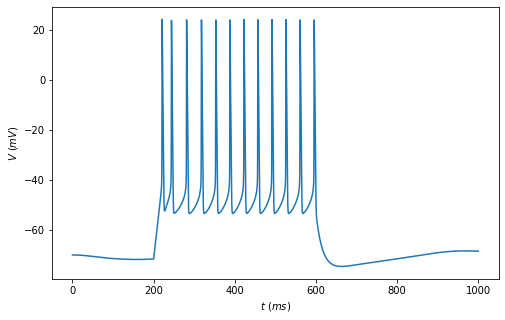

In [18]:
plt.figure(figsize = (8,5))
plt.plot(Time,Voltage)
xlabel('$t\ (ms)$')
ylabel('$V\ (mV)$');